## Import modules


In [24]:
from data_access.firebase_fhir_data_access import *
from data_flattening.fhir_resources_flattener import *
from data_processing.data_processor import *
from data_visualization.data_visualizer import *
from data_export.data_exporter import *

## Define credential files


In [25]:
# # Define your Firebase project ID
project_id = "cs342-2024-example-application" 

# # Define the service account key file
# service_account_key_file = "cs342-2024-example-application-firebase-adminsdk-z4ske-800739b1af.json"

# Define the collection name where your FHIR observations are stored and the input code if filtering is needed
collection_name = "users"
subcollection_name = "HealthKit"
loinc_codes = ["55423-8"] # "9052-2", "55423-8", "8867-4"

## Initialize the FirebaseFHIRAccess class using your Firebase credentials

In [26]:
# firebase_access = FirebaseFHIRAccess(project_id)
firebase_access.connect()

# Fetch FHIR observations from Firestore
fhir_observations = firebase_access.fetch_data(collection_name, subcollection_name, loinc_codes)

# Flatten the fetched FHIR observations into a FHIRDataFrame
flattened_fhir_dataframe = flatten_fhir_resources(fhir_observations)

In [27]:
flattened_fhir_dataframe.df.tail()

,UserId,EffectiveDateTime,QuantityName,QuantityUnit,QuantityValue,LoincCode,Display,AppleHealthKitCode
0,XrftRMc358NndzcRWEQ7P2MxvabZ,2023-04-26,Step Count,steps,1,55423-8,Number of steps in unspecified time Pedometer,HKQuantityTypeIdentifierStepCount
1,XrftRMc358NndzcRWEQ7P2MxvabZ,2023-06-28,Step Count,steps,170.0,55423-8,Number of steps in unspecified time Pedometer,HKQuantityTypeIdentifierStepCount
2,sEmijWpn0vXe1cj60GO5kkjkrdT4,2023-03-10,Step Count,steps,129.0,55423-8,Number of steps in unspecified time Pedometer,HKQuantityTypeIdentifierStepCount


## Apply basic processing for convenient data readability

In [17]:
processed_fhir_dataframe = FHIRDataProcessor().process_fhir_data(flattened_fhir_dataframe)
processed_fhir_dataframe.df.tail()

,UserId,EffectiveDateTime,LoincCode,QuantityValue,AppleHealthKitCode,QuantityUnit,QuantityName,Display
0,XrftRMc358NndzcRWEQ7P2MxvabZ,2023-04-26,55423-8,1,HKQuantityTypeIdentifierStepCount,steps,Total daily Step Count,Number of steps in unspecified time Pedometer
1,XrftRMc358NndzcRWEQ7P2MxvabZ,2023-06-28,55423-8,170.0,HKQuantityTypeIdentifierStepCount,steps,Total daily Step Count,Number of steps in unspecified time Pedometer
2,sEmijWpn0vXe1cj60GO5kkjkrdT4,2023-03-10,55423-8,129.0,HKQuantityTypeIdentifierStepCount,steps,Total daily Step Count,Number of steps in unspecified time Pedometer


## Visualize Data

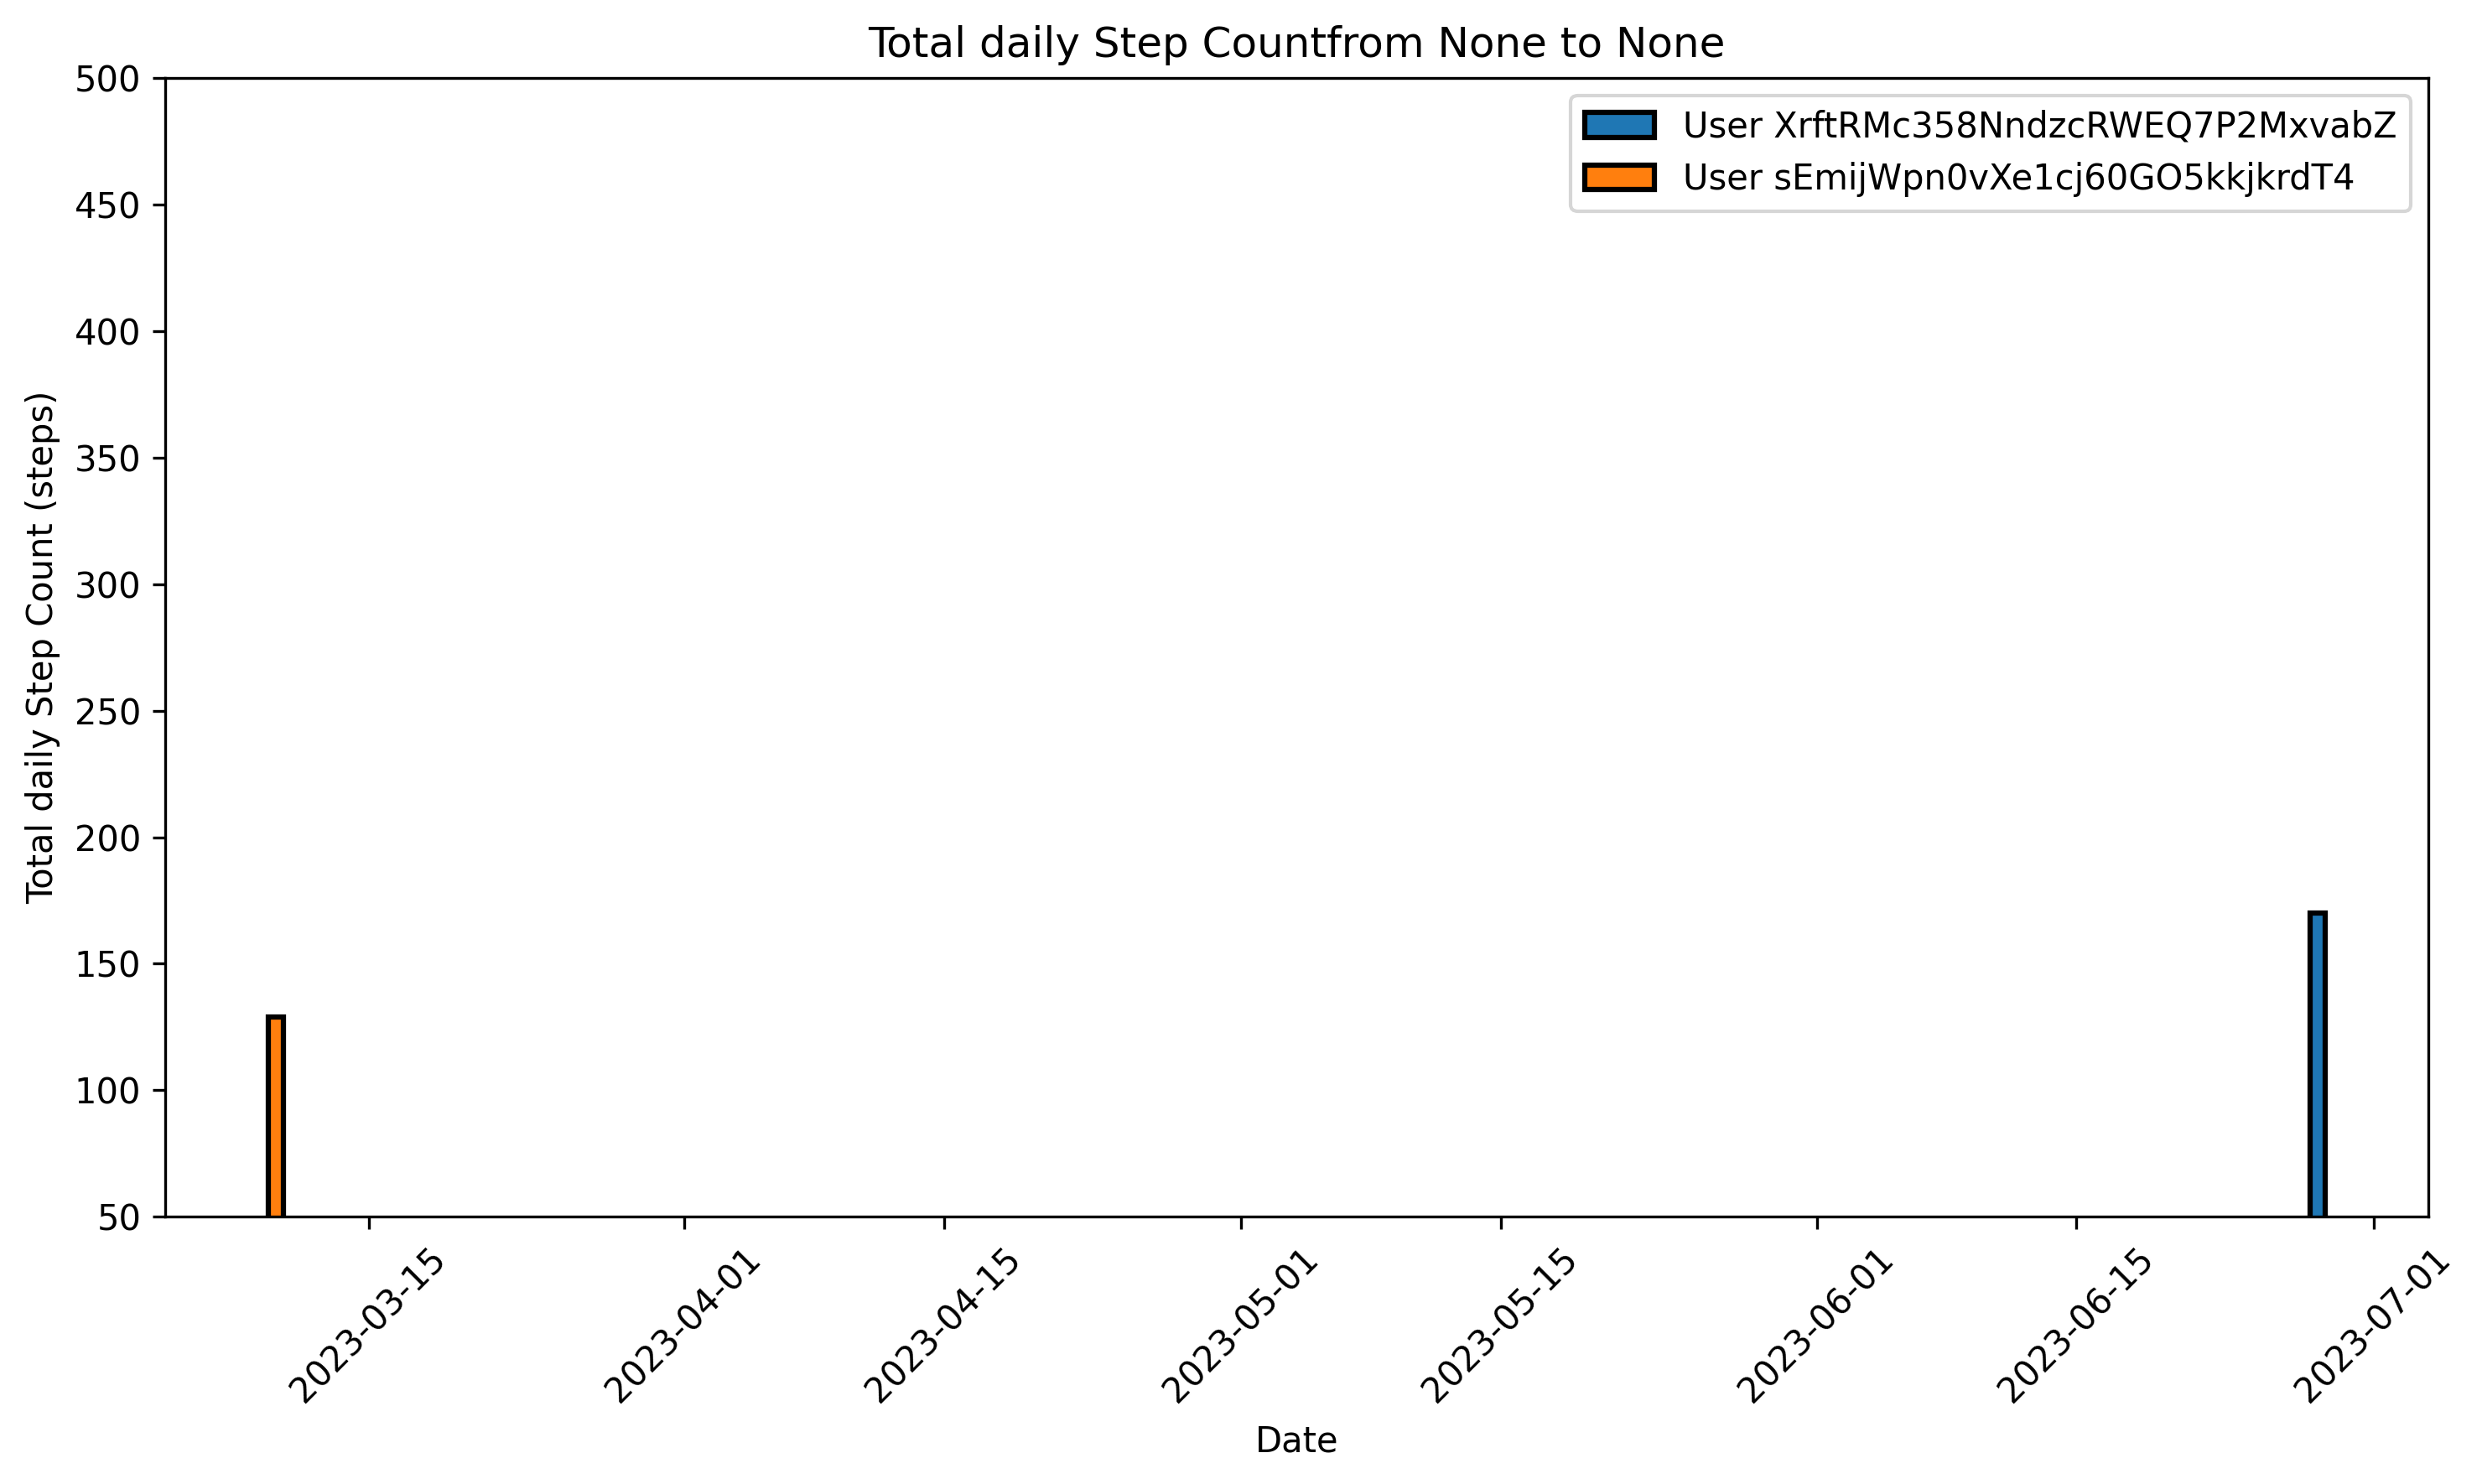

In [18]:
visualizer = DataVisualizer()
# selected_users = ["5okimXt6noCIcD4DGoB13wzXVJjY", "ys7YzmWeX0tKr1ilsXMiNaiZxGTk"]  # Use None to plot data for all users
# visualizer.set_user_ids(selected_users)
# visualizer.set_date_range("2022-01-01", "2023-01-31")
visualizer.set_y_bounds(50, 500)

fig = visualizer.create_static_plot(processed_fhir_dataframe)

## Export data

In [19]:
exporter = DataExporter(processed_fhir_dataframe)
# selected_users = ["sEmijWpn0vXe1cj60GO5kkjkrdT4"] 
# exporter.set_user_ids(selected_users)
# exporter.set_date_range("2022-01-01", "2022-12-31")
# exporter.set_y_bounds(50, 700)
exporter.create_and_save_plot("data_plot.tif")

Select a single user for enabling figure saving.


# Test Firebase query

In [1]:
# import json
# import os
# from typing import Any

# # Related third-party imports
# from firebase_admin import credentials, firestore
# import firebase_admin
# from google.cloud.firestore import (
#     CollectionReference,
#     DocumentReference,
#     DocumentSnapshot,
# )
# from google.cloud.firestore_v1.base_query import FieldFilter
# from data_access.firebase_fhir_data_access import get_code_mappings

# FIRESTORE_EMULATOR_HOST_KEY = "FIRESTORE_EMULATOR_HOST"
# project_id = "cs342-2024-example-application" 
# os.environ[FIRESTORE_EMULATOR_HOST_KEY] = "localhost:8080"
# os.environ["GCLOUD_PROJECT"] = project_id

# firebase_admin.initialize_app(options={"projectId": project_id})
# db = firestore.Client(  # pylint: disable=no-member
#     project=project_id
# )

# collection_name = "users"
# subcollection_name = "HealthKit"
# code = "55423-8"

In [4]:
# collection_ref = db.collection(collection_name)
# resources = []

# for user_doc in collection_ref.stream():
#     user_id = user_doc.id
#     print(user_id)
#     query = (
#             db.collection(collection_name)
#             .document(user_id)
#             .collection(subcollection_name)
#         )

#     display_str, code_str, system_str = get_code_mappings(code)
#     fhir_docs = query.where(
#         filter=FieldFilter(
#             "code.coding.0.code",
#             "==",
#             code_str
#             # {"code": code_str, "display": display_str, "system": system_str},
#         )
#     ).stream()    

#     for doc in fhir_docs:
#         observation_data = doc.to_dict()
#         print(observation_data)
#         observation_data['user_id'] = user_id
#         resources.append(observation_data)